# Content
[**Data Processing**](#data-proc) 
* [**Data Cleaning**](#cleaning) 
 
[**Analysis**](#analysis) 
- [**Growth of EV Stations**](#ev-st-growth) 
- [**Charger Types (Levels)**](#charge-levels) 
- [**EV Connector Types**](#conn-types)
- [**EV Pricing**](#ev-pricing) 
- [**Map of EV Locations (Interactive)**](#ev-map-interactive) 
    - [**Some Map Excerpts**](#map-excerpts)
    
[**Closing Remarks**](#closing) \
[**Sources**](#sources) \
[**Utility Functions**](#functions)


In [1]:
# imports

# data
import pandas as pd
import numpy as np
import statsmodels.api as sm

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# system operations
import os
import sys

# widgets
import ipywidgets as wgt
from ipywidgets import interactive

# import custom functions
own_package_paths = ['..\\src']
sys.path += own_package_paths

from processing import get_raw_data, bound_df_region
from visualization import plot_map


# ensure autoreload of edited imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data Processing <a class="anchor" id="data-proc"></a>

Data is retrieved from the file location or pulled directly from the source  website (API) when `update` is set to `True`

In [2]:
path = os.path.normpath(r'../data/raw/raw_data.csv')
raw_data = get_raw_data(path, update=False)
n_rows, n_cols = raw_data.shape
print(raw_data.shape)

(1779, 69)


The raw dataset is a subset of the alternative fuelling station dataset made available [here](https://natural-resources.canada.ca/energy-efficiency/transportation-alternative-fuels/electric-charging-alternative-fuelling-stationslocator-map/20487#/analyze?region=CA-BC&fuel=ELEC&status=E&status=P&country=CA) by Natural Resources Canada (NRCan). 

According to the website, NRCan *obtains information about new stations from trade media, the Submit New Station form on the Station Locator website, and through collaborating with infrastructure equipment and fuel providers, original equipment manufacturers (OEMs), and industry groups.* Also, station data points are checked annually and updated as necessary to ensure data integrity,.  

The subset in this work consist of records on electric vehicle (EV) charging stations across British Columbia, Canada. For the purposes of the analysis, the stations are further limited to the following properties:

- stations with public access
- stations that are available (denoted E) or or planned (denoted P)
- stations with level 2 or DC fast charging (DCFC) EVSE (electric vehicle supply equipment)


## Data Cleaning <a class="anchor" id="cleaning"></a>

- **remove constant columns**: Some columns are expected to be constant (single unique value) in the dataset given that there are columns used as filters.
Such columns are automatically removed to trim the raw data for downstream processing.

- **remove null columns**: columns where no values are unavailable for all stations are removed.

- **restrict to BC**: Later in the analysis, a station location outside of BC was found. The input dataset is filtered here to return only the subset 
    where the latitude and longitude values are within the boundaries set.

In [3]:
# British Columbia Boundaries. Source: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
BC_MAX_LAT = 60.00
BC_MAX_LON = -114.03
BC_MIN_LAT = 48.30
BC_MIN_LON = -139.06

BC_boundaries = {'lat_min':BC_MIN_LAT,
                'lat_max': BC_MAX_LAT,
                'lon_min': BC_MIN_LON,
                'lon_max':BC_MAX_LON}



# intitial data cleaning
df = (raw_data.loc[:, raw_data.nunique() != 1]  # drop constant column
      .dropna(axis=1, how='all')  # drop columns with no values
      .pipe(bound_df_region, boundaries=BC_boundaries) # trim datapoints outside BC
     )

print(df.shape)
n_stations_total, _ = df.shape
df.head(3)

(1776, 36)


access_days_time access_detail_code cards_accepted date_last_confirmed  \
0   24 hours daily                NaN            NaN          2020-03-05   
1   24 hours daily                NaN            NaN          2022-08-09   
2   24 hours daily                NaN            NaN          2022-08-09   

  expected_date groups_with_access_code     id   open_date owner_type_code  \
0           NaN                  Public  83426  2017-02-15               P   
1           NaN                  Public  83491  2020-08-21               P   
2           NaN                  Public  83492  2017-05-17               P   

  status_code  ...     ev_network ev_network_web                ev_pricing  \
0           E  ...  Non-Networked            NaN                      Free   
1           E  ...  Non-Networked            NaN  Free; donations accepted   
2           E  ...  Non-Networked            NaN                      Free   

  ev_renewable_source            access_days_time_fr  \
0                 NaN  Accessible 24 heures par jour   
1                 NaN             24 heures par jour   
2                 NaN  Accessible 24 heures par jour   

  intersection_directions_fr  groups_with_access_code_fr  \
0                        NaN                      Public   
1                        NaN                      Public   
2                        NaN                      Public   

            ev_pricing_fr ev_network_ids.station ev_network_ids.posts  
0                 Gratuit                    NaN                  NaN  
1  Gratuit; dons acceptés                    NaN                  NaN  
2                 Gratuit                    NaN                  NaN  

[3 rows x 36 columns]

To have a sense of the different columns, the unique values for the different columns are displayed below for reference.

In [4]:
df.apply(pd.unique)

access_days_time              [24 hours daily, Dealership business hours, 8a...
access_detail_code            [nan, CALL, LIMITED_HOURS, KEY_ALWAYS, CREDIT_...
cards_accepted                [nan, A Cash D Debit M V, Cash Debit M V, A M ...
date_last_confirmed           [2020-03-05, 2022-08-09, 2022-07-08, 2022-04-1...
expected_date                 [nan, 2022-10-01, 2022-11-15, 2022-09-01, 2022...
groups_with_access_code       [Public, Public - Call ahead, Public - Limited...
id                            [83426, 83491, 83492, 83527, 83550, 83732, 837...
open_date                     [2017-02-15, 2020-08-21, 2017-05-17, 2014-06-1...
owner_type_code                                             [P, T, LG, SG, nan]
status_code                                                              [E, P]
restricted_access                                            [False, True, nan]
station_name                  [City of Nanaimo - Underground Parking Lot, Fu...
station_phone                 [250-754-4

# Analysis <a class="anchor" id="analysis"></a>

## Growth of EV station <a class="anchor" id="ev-st-growth"></a>

Rapid adoption will require significant investments in EV. This sections focuses on investigation the growth in the number of stations.

First the number of existing and planned stations are shown below:

In [5]:
col = 'status_code'
print(df[col].value_counts())

E    1579
P     197
Name: status_code, dtype: int64


The result shows that there are just a few planned station and most of the stations in the dataset are available already.

The number of stations opened annually are shown below. But first, a check is made to ensure that all available stations are considered

In [6]:
df[df['open_date'].isna() & df['expected_date'].isna()].shape

(1, 36)

There is just one station without neither an expected/open date. This is negligible and would be ignored for the purposes of this analysis.

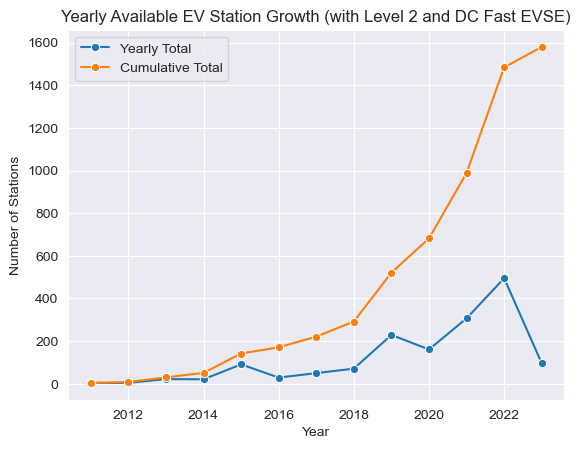

In [7]:
open_date = df['open_date'].copy()


# transformation
open_date_agg_df = (pd.DataFrame({'open_date':pd.to_datetime(open_date),'value': np.ones(len(open_date))})
                    .dropna()
                    .resample(rule='Y', on='open_date').agg({'value':np.sum})
                    .assign(cumsum = lambda x: np.cumsum(x['value']))
                    .assign(year=lambda x: x.index.year)
                    .reset_index())


# plot
sns.set_style("darkgrid")
fig, ax = plt.subplots()
sns.lineplot(x='year', y='value', marker='o', data=open_date_agg_df, label='Yearly Total', ax=ax)
sns.lineplot(x='year', y='cumsum', marker='o', data=open_date_agg_df, label='Cumulative Total', ax=ax)
ax.set_ylabel('Number of Stations');
ax.set_xlabel('Year')
ax.set_title('Yearly Available EV Station Growth (with Level 2 and DC Fast EVSE)');

# save
fig = plt.gcf()
fig.savefig('../reports/yearly-station-growth.png', bbox_inches='tight')

- A parabolic growth in the number of station is evident, which is somewhat expected given the push for EVs and the needed infrastructure. This is in tandem with the rapid growth [[ref]](https://www2.gov.bc.ca/assets/gov/farming-natural-resources-and-industry/electricity-alternative-energy/transportation/2021_zero_emission_vehicle_update.pdf) of EV  registrations in BC at over 54,400 in a 2021 report [[ref]](https://news.gov.bc.ca/releases/2021EMLI0039-001098#:~:text=More%20than%2054%2C400%20EVs%20are,in%20emission%20reductions%20per%20year.).
- It is still early days  in the 2023 and one might expect more stations to actually become available or planned given the trend.

- **caveat**:
    - For electric vehicle charging stations added to the Station Locator through automated data feeds from charging networks, this is either the date provided by the charging network or the date it appeared in the Station Locator if the charging network does not provide an open date.
    
The dataset also contains the expected date for the opening of new stations. At the current time some of those stations are now overdue as shown below.

The expected open date of the most overdue station is: 2020-09-01 


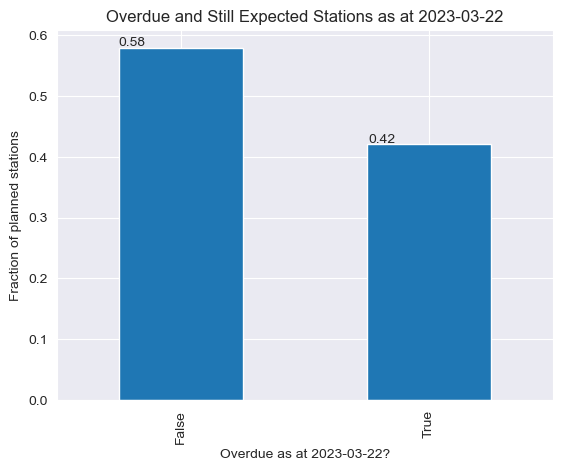

In [8]:
col_name = 'expected_date'
filter_condition = (df['expected_date'].notna()) & (df['open_date'].isna())
date_today = pd.to_datetime('today').normalize()

# transform
temp_df = (df[[col_name]][filter_condition]
 .apply(pd.to_datetime)
 .assign(overdue = lambda x: x[col_name] < date_today)
 .loc[:, 'overdue']
.value_counts(normalize=True)
)

# plot
temp_df.plot.bar()
ax = plt.gca()
ax.set_xlabel(f'Overdue as at {date_today.date()}?')
ax.set_ylabel("Fraction of planned stations")
ax.set_title(f"Overdue and Still Expected Stations as at {date_today.date()}");
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# check earliest expected date
earliest_exp_date = pd.to_datetime(df['expected_date']).min()
print(f"The expected open date of the most overdue station is: {earliest_exp_date.date()} ");

The figure shows that of the 197 stations planned, about 42% are already overdue as at 2023-03-22. It is possible that development is behind schedule on some of these stations. But with with some stations about two years overdue (earliest overdue date is 2020-09-01), plans may have been permanently halted for some planned stations.

## Charger Types (Levels) <a class="anchor" id="charge-levels"></a>

In the dataset, two EV charging level considered — level 2 and DC fast (DCFC or level 3). These levels are indicative of the charging power that may be delivered by the chargers. 
DCFC enables relatively faster charging (about 1 hour) than level 2 chargers (about 4 hours) which are in turn faster than level 1 (about 20 hours) chargers [[ref]](https://www.chargepoint.com/files/Quick_Guide_to_Fast_Charging.pdf).

First the number of the stations with at least one of the charging level types is considered.

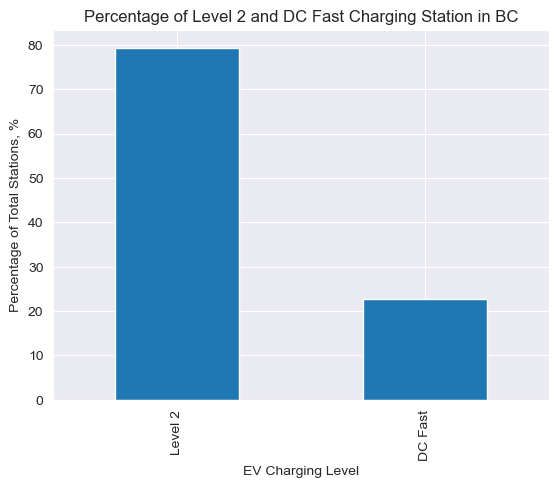

In [9]:

# transformation
charger_type_names =  ('ev_level2_evse_num', 'ev_dc_fast_num')
charger_type_new_names = ('Level 2', 'DC Fast')

temp_df = (df[list(charger_type_names)].copy()
          .rename(columns={charger_type_names[0]:charger_type_new_names[0],
                            charger_type_names[1]:charger_type_new_names[1]})
           .apply(lambda x: sum(x > 0) *100 / n_stations_total)
          )

# plot
temp_df.plot.bar()
ax = plt.gca()
ax.set_ylabel('Percentage of Total Stations, %')
ax.set_xlabel('EV Charging Level')
ax.set_title('Percentage of Level 2 and DC Fast Charging Station in BC');

# save
fig = plt.gcf()
fig.savefig('../reports/Number-of-Level-2-and-DC-FC-stations.png', bbox_inches='tight')

The figure above shows the number of stations with level 2 and DCFC charging capabilities. 

The result shows that level 2 chargers are more available at about 79% of the stations compared to just about 23% of stations with DC fast charging. This is reasonable given that the DC fast stations are a latter technology and also significantly more expensive.

A cursory look at the data shows that the stations have a varying number of ports for each charger type. The distribution of the number of ports of each charger type is presented below.

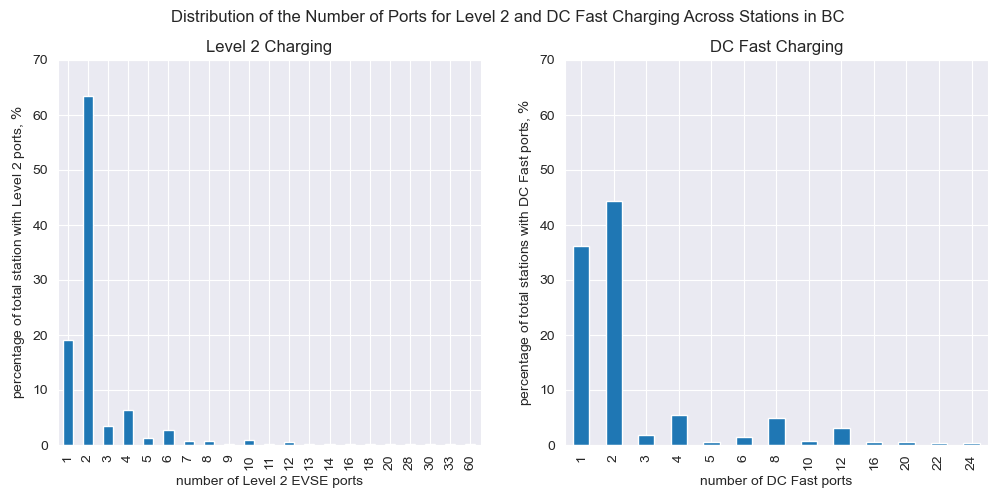

In [10]:

# transformation
l2_col_name = 'ev_level2_evse_num'
dcfc_col_name = 'ev_dc_fast_num'

temp_df_l2 = (df[[l2_col_name]].copy()
                 .dropna()
                 .astype('int')
                 .groupby(l2_col_name).apply(lambda x: 100.0*(x.count() / df[l2_col_name].notnull().sum()))
                )

temp_df_dcfc = (df[[dcfc_col_name]].copy()
                 .dropna()
                 .astype('int')
                 .groupby(dcfc_col_name)
                 .apply(lambda x: 100.0*(x.count() / df[dcfc_col_name].notnull().sum()))
                )


# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = axs

temp_df_l2.plot.bar(ax=ax1)
temp_df_dcfc.plot.bar(ax=ax2)

ax1.set_ylabel('percentage of total station with Level 2 ports, $\%$')
ax1.set_xlabel('number of Level 2 EVSE ports')

ax2.set_ylabel('percentage of total stations with DC Fast ports, $\%$')
ax2.set_xlabel('number of DC Fast ports')

ax1.set_ylim(0, 70)
ax2.set_ylim(0, 70)

ax1.legend().remove()
ax2.legend().remove()

ax1.set_title('Level 2 Charging')
ax2.set_title('DC Fast Charging')

plt.suptitle('Distribution of the Number of Ports for Level 2 and DC Fast Charging Across Stations in BC');

# save
fig = plt.gcf()
fig.savefig('../reports/distribution of ports count.png', bbox_inches='tight')

The figure represents the distribution of the number of level 2 and DCFC ports available at the various stations. Evidently, stations with two charging ports are most common, followed by single-port ones for both level 2 and DCFC charging. 

The maximum nuber of level 2 ports and DCFC ports are 60 and 24, respectively. Expectedly, stations with such high port numbers are very limited.

## EV Connector Type <a class="anchor" id="conn-types"></a>

Another point of interest for EV charing is the connector types. While there have been some effort to standardize EV infrasture, the nascent nature of the transition means that various standards still exist. 

EVSE stations across BC support various connector types as shown below.

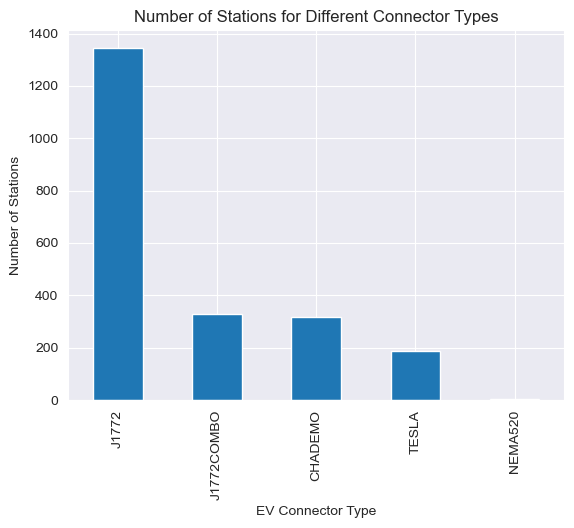

ev_connector_types  ev_level1_evse_num  ev_level2_evse_num  \
23             ['J1772', 'NEMA520']                 1.0                 1.0   
77  ['CHADEMO', 'J1772', 'NEMA520']                 2.0                 6.0   

    ev_dc_fast_num     city  
23             NaN  Kelowna  
77             2.0  Burnaby

In [11]:
# transformation
from ast import literal_eval
col_name = 'ev_connector_types'

temp_df = (df[col_name].copy()
 .rename('Connector Types')
 .dropna()
 .apply(literal_eval)  # change list like string to lists
 .explode()
 .value_counts()
)

# plot
temp_df.plot.bar()
ax = plt.gca()
ax.set_xlabel('EV Connector Type')
ax.set_ylabel('Number of Stations');
ax.set_title('Number of Stations for Different Connector Types')

# plot
fig = plt.gcf()
fig.savefig('../reports/count of connection types.png', bbox_inches='tight')
plt.show()

# check NEMA520 locations
idxs = []
for i, item in enumerate(df[col_name].values):
    if 'NEMA520' in str(item):
        idxs.append(i)
(df.loc[idxs, ['ev_connector_types','ev_level1_evse_num' ,'ev_level2_evse_num', 'ev_dc_fast_num', 'city']])



The different connector types available in BC stations include the J1772, J1772COMBO, CHADEMO, TESLA, and NEMA520. 

The (SAE) J1772 is known to be most popular in North America for level 2 (and level 1) chargers and it is shown to be available in much higher numbers than other connector type[[ref]](https://chargehub.com/en/electric-car-charging-guide.html). TESLA connector types work for level 1, 2 and DCFC needs.

There are just 2 NEMA520 connector types available in BC. These connectors types which are for level 1 charging [[ref]](https://chargehub.com/en/electric-car-charging-guide.html) are available only at Kelowna and Burnaby.

The other connector types — J1772COMBO, CHADEMO (including  TESLA) are available for DCFC charging. J1772COMBO is expected to increase in popularity given it wide acceptance among automakers.

## EV Pricing <a class="anchor" id="ev-pricing"></a>

The cost of charging and availability of some form of free charging is relevant information particularly for EV users.

First, the relevant column in examined below:

In [12]:
print(df[['ev_pricing']]
      .notna()
      .value_counts(normalize=True)
      .reset_index()
      .set_axis(['has price info?','fraction'], axis=1), '\n')
print(df['ev_pricing'].unique())


   has price info?  fraction
0            False  0.777027
1             True  0.222973 

['Free' 'Free; donations accepted' nan '$0.35 per kWh'
 '$3 per hour first 4 hours, $6 per hour for any additional hours'
 'Charging free, parking fee required' 'Free; parking fee required'
 '$5 per session' 'Free for guests'
 '$3.50 per hour for first hour, $4 per hour after' 'Free; parking fee'
 'Variable Fee' 'DC fast: $0.35 per kWh; $2 minimum'
 'Variable parking fee'
 '$0.44 per minute above 60 kW and $0.22 per minute at or below 60 kW'
 '$3 per hour' '$0.21 per minute' 'DCFC: $0.21 per minute'
 '$0.22 per minute' 'Free; $2.0 per hour parking fee' '$2 per hour'
 '$2.00/Hr Parking Fee' 'FREE' '$0.27 per minute' '$0.21 per hour'
 '$0.2113 (CAD) per minute plus tax' '$0.30 per minute'
 'L2: Free; DC Fast: $0.27 per minute' 'DCFC: $0.21 per minute; L2: Free'
 '$0.00-$1.00/Hr Variable Parking Fee' '$1.00 per hour' '$1 per hour'
 '$1.50-$5.50/Hr Variable Parking Fee' '$1.50 per hour'
 'Free for firs

The results above show that most of the station have no pricing information in the dataset.

For the few data points with pricing information, there are a variety of pricing rates available. Some stations offer  some form of free charing service ranging from completely free, to  subsidized in some form. 

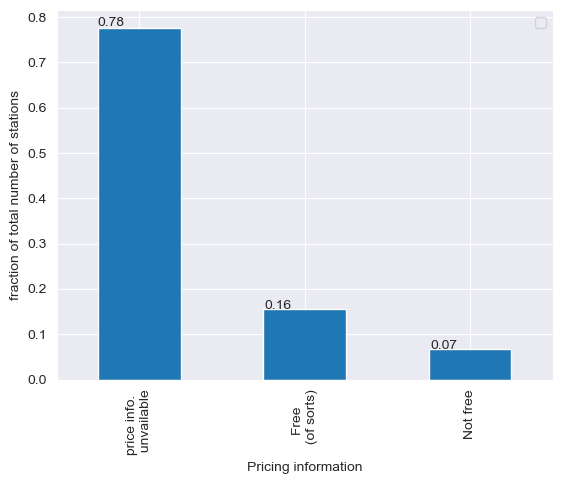

In [13]:

# transformation
temp_df = (df['ev_pricing'].copy()
 .str.contains('free', case=False)
 .value_counts(normalize=True, dropna=False)
 .reset_index()
 .replace({True:'Free \n (of sorts)',
         False: 'Not free',
          np.NaN: 'price info. \n unvailable'})
 .set_index('index')
)

# plot
temp_df.plot.bar();
ax = plt.gca()
ax.set_xlabel('Pricing information')
ax.set_ylabel('fraction of total number of stations');
ax.legend('');
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# save
fig = plt.gcf()
fig.savefig('../reports/pricing-info.png', bbox_inches='tight')

The figure shows that about 16% of the stations can be said to offer some form of free charging, while 7% requires paying a fee. If the distribution between free and paid is also true for stations without price information, then msot stations will indeed be free. 

The availability of free charging station is likely an effort to incentivize EV usage. As EVs gain a larger share of vehicles on the road, free charging may become a thing of the past as it happens with most incentivised technoligy. 

## Map of EV locations <a class="anchor" id="ev-map-interactive"></a>

The number of EV stations are expected to be higher in high demand regions or locations of high vehicular use. Below is an interactive map of station locations in BC. Stations are indicated by the blue circles with radius representative of the relative total number of charging ports (L2 or DCFC) available.

The following control widgets (notebook need to be properly setup to use) are included to provide relevant filtering of the stations:

- `status`: this enables the filtering of the station locations to either include only available stations (E), planned stations (P), or all stations
- `Min. # of L2 ports`: filters by showing only those station locations where the number of level 2 charging ports are greater than the set minimum 
- `Min. # of DCFC ports`: filters by showing only those station locations where the number of DC fast charging ports are greater than the set minimum.
- `Free charging available`: when checked, only stations with some form of available free charging are displayed on the map. Otherwise, all stations are shown.

In [14]:

# transformation
col_names = ['id','longitude', 'latitude', 'ev_level2_evse_num', 
             'ev_dc_fast_num', 'ev_connector_types', 'status_code',
             'ev_pricing','street_address' ]

temp_df = (df[col_names].copy()
           .fillna({'ev_level2_evse_num':0,
                   'ev_dc_fast_num':0})
           .assign(free_charging=lambda x: x['ev_pricing']
                   .str.contains('free', case=False))
          )

# plot

style = {'description_width': 'initial'}
status_list = ['all'] + list(df['status_code'].unique())

# create widgets
max_l2_ports = temp_df['ev_level2_evse_num'].max()
max_dcfc_ports = temp_df['ev_dc_fast_num'].max()

status_val = wgt.Dropdown(options=status_list, description='status:')
free_charging = wgt.Checkbox(value=False, description='Free charging available')
l2_port_min = wgt.IntSlider(value=0, min=0, step=1, max=max_l2_ports, description='Min. # of L2 ports:', style=style )
dcfc_port_min = wgt.IntSlider(value=0, min=0, step=1, max=max_dcfc_ports, description='Min. # of DCFC ports:', style=style)


interactive(plot_map, 
            data=wgt.fixed(temp_df),
            status=status_val, 
            min_l2_ports=l2_port_min,
            min_dcfc_ports=dcfc_port_min,
            free_charging=free_charging)

interactive(children=(Dropdown(description='status:', options=('all', 'E', 'P'), value='all'), IntSlider(value…

A few observations from the map:

- **distribution**: A quick glance shows that most of the stations are concentrated in the lower mainaland. This is reasonable given that this regions is home to most of the province's population. There is also a significant concentration in the province capital — Victoria. 

- **station size**: most of the large stations (high number of ports) are also clustered in these two regions. The stations with the largest number of ports may be found at 3700 Willingdon Ave in Burnaby, with 60 level 2 EVSE ports. However, the largest collection of DCFC ports is located at an EV charging station at 19700 Klassen Road (Hope BC). Apparently, this station consists of Tesla supercharing infrastructure.

- **free charing**: as shown earlier, few stations in the dataset have any form pricing information. The location distribution of stations with some form of free charging is similar to the overall distribution. The largest of this, with about 30 L2 ports may be found in 7000 Westminster Hwy in Richmond.

- **planned installation**: new stations (status: P) are due to be added to existing ones (status E) across the province, with the largest of 33 ports to be sited at 3585 Graveley Street






### Some Map Excerpts <a class="anchor" id="map-excerpts"></a>

Some notable snapshots, such as the station with the highest number of level 2 EVSE ports, are generated below

In [15]:

# dict of a few interesting snapshots and relevant parameters
snap_shots_params = {
    'all-stations':{'status':'all'},
    'station-with-maximum-number-of-ports':{ 'min_l2_ports':60},
    'planned-stations-only': {'status':'E'},
    'staions-with-free-charging':{'free_charging':True},
    'stations-with-fast-charging-capability':{'min_dcfc_ports':1}
}

for k, v in snap_shots_params.items():
    print(f"**{k}**")
    m = plot_map(data=temp_df, **v)
    save_path = os.path.normpath(f"../reports/{k}.html")
    m.save(save_path)

**all-stations**


**station-with-maximum-number-of-ports**


**planned-stations-only**


**staions-with-free-charging**


**stations-with-fast-charging-capability**


# Closing

The above above work analyzed public EV stations in BC using a subset of the dataset available at [NRCan website](https://natural-resources.canada.ca/energy-efficiency/transportation-alternative-fuels/electric-charging-alternative-fuelling-stationslocator-map/20487#/analyze?region=CA-BC&fuel=ELEC&status=E&status=P&country=CA). The subset analyzed in this work focused only on stations with level 2 or DC fast charging capabilities and those existing or planned stations.

The analysis covered areas such as the growth of stations, the different available charging level types and connector types. The pricing of EV charing is also gleaned from the rather unstructure and scanty information available. 

The results showed that EV stations numbers are growing rapidly to meet the equally rapid growth in EV adoption. Currently, about 1579 stations are available while 197 are planned to open. While level 2 and DC fast charging is available, Level 2 charging ports are more commonly available.  There are charging stations with up to 60 charging ports,  although most of the stations have just 2 ports.

The generated map visualization shows that higher number of stations are located in densely populatedregions such as the lower mainland and victoria.

## Data Quality

The raw data was quite easy to work with with little cleaning to do. The following are recommendations to improve the quality.

- pricing information is unavailable for most ot the data points, and where it is available, it seems to be currently formatted to accept an open text. Pricing information should be included for more stations and such information needs to be collected in more specified format to ease data analysis
- the dataset includes a location well outside of BC (in Quebec). Such cases may be prevented by performing an integrity check on latitude and longitude values when such information is provided.


## Recommendation Future Investigation

The provides a basis for more interesting analysis. Given more time and resources, I would be interested in investigating the followig:

- Combining this dataset with traffic patterns to determine EVSE infrastructure needs. This could inform infrastructure planning and the optimization of EV station locations as a function of demand proximity

I hope you enjoyed reading this as much I did putting it together! Thanks.

# Sources <a class="anchor" id="sources"></a>

1. https://www.chargepoint.com/files/Quick_Guide_to_Fast_Charging.pdf
2. https://www.evgo.com/ev-drivers/charging-basics/
3. https://electricvehicles.bchydro.com/charge/choosing-a-home-EV-charger

# Utility Functions <a class="anchor" id="functions"></a>

The content of the custom functions imported throughout the analysis are again provided here for viewing

In [16]:
# %load ../src/processing.py
import pandas as pd
import os
import requests

def get_raw_data(file_path, update=False):
    
    '''retrieve exisiting raw data either from `file_path` or from api if update=True.
    data is saved for future retrival
    '''
    
    if not update:
        try:
            data = pd.read_csv(file_path)
        except FileNotFoundError:
            print("file does not exist, downloading data instead")
            data = _pull_data()
            data.to_csv(file_path, index=False)
    else:
        data = _pull_data()
        data.to_csv(file_path, index=False)
        
    data = pd.read_csv(file_path)  
    
    
    return data
        
def bound_df_region(df, boundaries):
    '''
    This filters the input dataset and returns only the subset 
    where the latitude and longitude values are within the boundaries set.
    
    Note: This was needed to catch some outlier location (somewhere in Quebec) 
    points seen when visualizing the map later in the analysis
    '''
    region_only_df = df[(df['latitude'] >= boundaries['lat_min']) &
                   (df['latitude'] <= boundaries['lat_max']) &
                    (df['longitude'] >= boundaries['lon_min']) &
                    (df['longitude'] <= boundaries['lon_max'])
                   ].copy()
    
    return region_only_df
    
def _pull_data():
    """queries api to retrieve data filtered by query parameters and returns a dataframe object"""
    api_key = os.environ['API_KEY']
    query_params = {'api_key':api_key, 
                'country':'CA',
                'state':'BC',
               'access':'public',
               'status':'E,P',
               'owner_type': 'all',
               'cards_accepted': 'all',
               'fuel_type':'ELEC',
               'ev_charging_level':'2,dc_fast',
               'ev_connector_type': 'all',
               'ev_network':'all'}
    response = requests.get("http://developer.nrel.gov/api/alt-fuel-stations/v1.json", params=query_params)
    r_dict = response.json()
    raw_data = pd.json_normalize(r_dict['fuel_stations'])
    
    return raw_data

In [17]:
# %load ../src/visualization.py
import folium
from IPython.display import  display

def plot_map(data, status='all', min_l2_ports=0, min_dcfc_ports=0, free_charging=False):

    """
    Generates a folium map using data available in `data` and filtered by the other function arguments
    """

    if status=='all':
        select_df = data.copy()
    else:
        select_df = data[data['status_code'] ==status].copy()
    

    condition = (select_df['ev_level2_evse_num']>=min_l2_ports) & (select_df['ev_dc_fast_num']>=min_dcfc_ports)
    
    select_df = select_df[condition].copy()
    
    if free_charging:
        select_df = select_df[select_df['free_charging']==free_charging].copy()

    def _plot(select_df):
        
        m = folium.Map(location=[49.2827, -123.1207], tiles="OpenStreetMap", zoom_start=9)
        
        for _, id in enumerate(select_df.id):

            row = select_df[select_df['id']==id]

            status_code = row['status_code'].iloc[0]
            n_l2_ports = row['ev_level2_evse_num'].iloc[0]
            n_dcfc_ports = row['ev_dc_fast_num'].iloc[0]
            address = row['street_address'].iloc[0]

            popup = folium.Popup(f"# of L2 ports:{n_l2_ports} <br> \
                                # of DCFC ports:{n_dcfc_ports} <br> \
                                 status: {status_code} <br> \
                                 address: {address}", 
                                min_width=300, max_width=300)
            folium.CircleMarker([row.latitude, row.longitude],
                                popup=popup,
                                #icon=folium.Icon(color='green', icon='charging-station', prefix='fa')
                                radius=(n_l2_ports+n_dcfc_ports) / 4.0,
                                opacity=0.8
                               ).add_to(m)

        return m
    
    m = _plot(select_df)
    display(m)
    
    return m   